In [1]:
# enabling 3rd party widgets
# from google.colab import output
# output.enable_custom_widget_manager()
# output.disable_custom_widget_manager()

# interactive 3D plot
# !pip install ipympl
# %matplotlib widget

In [2]:
import os
import math
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg

import time as time
import platform as platform

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import L2
from keras.engine import data_adapter
import h5py

tf.keras.backend.set_floatx('float32')

plt.rcParams.update({
    "text.usetex":True,
    "font.family":"serif"
})

In [3]:
colab_flag = False
FTYPE = np.float32
ITYPE = np.int32

strategy = None
# strategy = tf.distribute.MirroredStrategy()

In [4]:
current_sys = platform.system()

if current_sys == 'Windows':
    dir_sep = '\\'
else:
    dir_sep = '/'

In [5]:
if colab_flag == True:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Github/MLROM/KS/')

In [6]:
print(os.getcwd())

/home/rkaushik/Documents/Thesis/MLROM/new_ks


In [7]:
from tools.misc_tools import create_data_for_RNN, mytimecallback, SaveLosses, plot_losses, plot_reconstructed_data_KS, plot_latent_states_KS , readAndReturnLossHistories, plot_histogram_and_save
from tools.ae_v1 import Autoencoder
from tools.GRU_AR_v1 import AR_RNN_GRU as AR_RNN
# from tools.LSTM_AR_v2 import AR_RNN_LSTM as AR_RNN
from tools.AEGRU_AR_v1 import AR_AERNN_GRU
from tools.trainAERNN import trainAERNN

In [8]:
behaviour = 'initialiseAndTrainFromScratch'
# behaviour = 'loadCheckpoin?tAndContinueTraining'
# behaviour = 'loadFinalNetAndPlot'

In [9]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)

if colab_flag == False:
    if strategy is None:
        if gpus:
            gpu_to_use = 0
            tf.config.set_visible_devices(gpus[gpu_to_use], 'GPU')
    logical_devices = tf.config.list_logical_devices('GPU')
    print(logical_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2023-06-28 04:59:15.244701: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-28 04:59:15.245198: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-28 04:59:15.311034: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-28 04:59:15.311351: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-06-28 04:59:15.311631: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [10]:
# print(tf.test.gpu_device_name())
print(tf.config.list_physical_devices())
print('')
print(tf.config.list_logical_devices())
print('')
print(tf.__version__)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

[LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]

2.8.1


# KS System

In [11]:
# setting up params (and saving, if applicable)
from numpy import *

if behaviour == 'initialiseAndTrainFromScratch':
    # RNN directory
    dir_name_rnn = os.getcwd()+'/saved_rnn/rnn_000'

    # making AR-RNN save directory
    dir_name_ARrnn = os.getcwd() + dir_sep + 'saved_AR_AERNN_rnn'
    if not os.path.isdir(dir_name_ARrnn):
        os.makedirs(dir_name_ARrnn)

    counter = 0
    while True:
        dir_check = 'AR_rnn_' + str(counter).zfill(3)
        if os.path.isdir(dir_name_ARrnn + dir_sep + dir_check):
            counter += 1
        else:
            break

    dir_name_ARrnn = dir_name_ARrnn + dir_sep + dir_check
    os.makedirs(dir_name_ARrnn)
    os.makedirs(dir_name_ARrnn+dir_sep+'plots')
    
    # reading RNN paramaters
    with open(dir_name_rnn + '/RNN_specific_data.txt') as f:
        lines = f.readlines()

    params_rnn_dict = eval(''.join(lines))

    dt_rnn = params_rnn_dict['dt_rnn']
    return_params_arr = params_rnn_dict['return_params_arr']
    params = params_rnn_dict['params']
    try:
        normalize_dataset = params_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in rnn_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        normalization_type = params_rnn_dict['normalization_type']
    except:
        print("'normalization_type' not present in RNN_specific_data, set to 'stddev'.")
        normalization_type = 'stddev'
    try:
        dense_layer_act_func = params_rnn_dict['dense_layer_act_func']
    except:
        print("'dense_layer_act_func' not present in RNN_specific_data, set to 'linear'.")
        dense_layer_act_func = 'linear'
    try:
        stateful = params_rnn_dict['stateful']
    except:
        print("'stateful' not present in RNN_specific_data, set to True.")
        stateful = True
    try:
        use_learnable_state = params_rnn_dict['use_learnable_state']
    except:
        print("'use_learnable_state' not present in RNN_specific_data, set to False.")
        use_learnable_state = False
    try:
        use_weights_post_dense = params_rnn_dict['use_weights_post_dense']
    except:
        print("'use_weights_post_dense' not present in RNN_specific_data, set to False.")
        use_weights_post_dense = False
        
    
    # training params
    with open(dir_name_rnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
    try:
        fRMS = tparams_dict['fRMS']
    except:
        fRMS = 0.0

    loss_weights = 0.98
else:
    # AR-RNN directory
    dir_name_ARrnn = os.getcwd()+'/saved_AR_AERNN_rnn/AR_AErnn_000'

    # reading AR-RNN parameters
    with open(dir_name_ARrnn + '/AR_rnn_specific_data.txt') as f:
        lines = f.readlines()
    
    params_AR_rnn_dict = eval(''.join(lines))

    dir_name_rnn = params_AR_rnn_dict['dir_name_rnn']
    rnn_idx = dir_name_rnn[-3:]
    dir_name_rnn = os.getcwd()+'/saved_rnn/rnn_'+rnn_idx

    dt_rnn = params_AR_rnn_dict['dt_rnn']
    T_sample_input = params_AR_rnn_dict['T_sample_input']
    T_sample_output = params_AR_rnn_dict['T_sample_output']
    T_offset = params_AR_rnn_dict['T_offset']
    return_params_arr = params_AR_rnn_dict['return_params_arr']
    params = params_AR_rnn_dict['params']
    try:
        normalize_dataset = params_AR_rnn_dict['normalize_dataset']
    except:
        print("'normalize_dataset' not present in AR_rnn_specific_data, set to False.")
        normalize_dataset = False
    try:
        stddev_multiplier = params_AR_rnn_dict['stddev_multiplier']
    except:
        print("'stddev_multiplier' not present in RNN_specific_data, set to None.")
        stddev_multiplier = None
    try:
        skip_intermediate = params_AR_rnn_dict['skip_intermediate']
    except:
        print("'skip_intermediate' not present in RNN_specific_data, set to 1.")
        skip_intermediate = 1
    try:
        use_ae_data = params_AR_rnn_dict['use_ae_data']
    except:
        print("'use_ae_data' not present in RNN_specific_data, set to True.")
        use_ae_data = True

    # training params
    with open(dir_name_ARrnn + dir_sep + 'training_specific_params.txt') as f:
        lines = f.readlines()

    tparams_dict = eval(''.join(lines))

    learning_rate_list = tparams_dict['learning_rate_list']
    epochs = tparams_dict['epochs']
    patience = tparams_dict['patience']
    min_delta = tparams_dict['min_delta']
    prng_seed = tparams_dict['prng_seed']
    train_split = tparams_dict['train_split']
    val_split = tparams_dict['val_split']
    batch_size = tparams_dict['batch_size']
    try:
        fRMS = tparams_dict['fRMS']
    except:
        fRMS = 0.0
    try:
        loss_weights = tparams_dict['loss_weights']
    except:
        loss_weights = None
    if 'freeze_layers' in tparams_dict.keys():
        freeze_layers = tparams_dict['freeze_layers']
    else:
        freeze_layers = None
    if 'clipnorm' in tparams_dict.keys():
        clipnorm = tparams_dict['clipnorm']
    else:
        clipnorm = None
    


# reading stddev
with open(dir_name_rnn + '/final_net/final_net_class_dict.txt') as f:
    lines = f.readlines()
finalnet_dict = eval(''.join(lines))
stddev = finalnet_dict['stddev']
# stddev = 0.0

# reading RNN normalization constants
normalization_arr_rnn = None
if normalize_dataset == True:
    with open(dir_name_rnn + '/final_net/rnn_normalization.txt') as f:
        lines = f.readlines()
    normarr_rnn_dict = eval(''.join(lines))
    normalization_arr_rnn = normarr_rnn_dict['normalization_arr']

if os.path.exists(dir_name_rnn+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_rnn+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_arr_rnn = fl['normalization_arr'][0]

# reading AE directory
with open(dir_name_rnn + '/sim_data_AE_params.txt') as f:
    lines = f.readlines()

params_dict = eval(''.join(lines))

dir_name_ae = params_dict['dir_name_ae']
ae_idx = dir_name_ae[-3:]
dir_name_ae = os.getcwd()+'/saved_ae/ae_'+ae_idx
try:
    use_ae_data = params_dict['use_ae_data']
except:
    print("'use_ae_data' not present in sim_data_AE_params, set to True.")
    use_ae_data = True

# reading simulation parameters
with open(dir_name_ae + dir_sep + 'ae_data.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
data_dir_idx = params_dict['data_dir_idx']
normalizeforae_flag = params_dict['normalizeforae_flag']
normalization_constant_arr_aedata = params_dict['normalization_constant_arr_aedata']
if os.path.exists(dir_name_ae+dir_sep+'normalization_data.npz'):
    with np.load(dir_name_ae+dir_sep+'normalization_data.npz', allow_pickle=True) as fl:
        normalization_constant_arr_aedata = fl['normalization_constant_arr_aedata'][0]
try:
    ae_data_with_params = params_dict['ae_data_with_params']
except:
    print("'ae_data_with_params' not present in RNN_specific_data, set to True.")
    ae_data_with_params = True

print('dir_name_AR_AErnn:', dir_name_ARrnn)
print('dir_name_rnn:', dir_name_rnn)
print('dir_name_ae:', dir_name_ae)
print('data_dir_idx:', data_dir_idx)

# loading data
dir_name_data = os.getcwd() + dir_sep + 'saved_data' + dir_sep + 'data_' + data_dir_idx
    
with open(dir_name_data + dir_sep + 'sim_data_params.txt') as f:
    lines = f.readlines()
params_dict = eval(''.join(lines))
params_mat = params_dict['params_mat']
# init_state_mat = params_dict['init_state_mat']
t0 = params_dict['t0']
T = params_dict['T']
delta_t = params_dict['delta_t']
numpoints_xgrid = params_dict['numpoints_xgrid']
length = params_dict['length']
return_params_arr = params_dict['return_params_arr']
normalize_flag_ogdata = params_dict['normalize_flag']
print('normalize_flag_ogdata:', normalize_flag_ogdata)
alldata_withparams_flag = params_dict['alldata_withparams_flag']

xgrid = length*np.linspace(0, 1, numpoints_xgrid)

with np.load(dir_name_data+dir_sep+'data.npz', allow_pickle=True) as fl:
    all_data = fl['all_data']
    boundary_idx_arr = fl['boundary_idx_arr']
    normalization_constant_arr_ogdata = fl['normalization_constant_arr'][0]
    initial_t0 = fl['initial_t0']
    init_state_mat = fl['init_state_mat']
    lyapunov_spectrum_mat = fl['lyapunov_spectrum_mat']


test_split = 1 - train_split - val_split

# setting seed for PRNGs
np.random.seed(prng_seed)
tf.random.set_seed(prng_seed)

dir_name_AR_AErnn: /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AERNN_rnn/AR_rnn_002
dir_name_rnn: /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_rnn/rnn_000
dir_name_ae: /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_ae/ae_000
data_dir_idx: 000
normalize_flag_ogdata: False


In [12]:
lyapunov_time_arr = np.empty(shape=lyapunov_spectrum_mat.shape[0], dtype=FTYPE)
for i in range(lyapunov_spectrum_mat.shape[0]):
    lyapunov_time_arr[i] = 1/lyapunov_spectrum_mat[i, 0]
    print('Case : {}, lyapunov exponent : {}, lyapunov time : {}s'.format(i+1, lyapunov_spectrum_mat[i, 0], lyapunov_time_arr[i]))

Case : 1, lyapunov exponent : 0.06465670311438651, lyapunov time : 15.466300964355469s


In [13]:
# delaing with normalizing the data before feeding into autoencoder
num_params = params_mat.shape[1]
og_vars = all_data.shape[1]
if alldata_withparams_flag == True:
    og_vars -= num_params

# if use_ae_data == True:
#     if ae_data_with_params == True and alldata_withparams_flag == False:
#         new_all_data = np.empty(shape=(all_data.shape[0], og_vars+num_params), dtype=FTYPE)
#         new_all_data[:, 0:og_vars] = all_data[:, 0:og_vars]
#         del(all_data)
#         all_data = new_all_data
#         prev_idx = 0
#         for i in range(boundary_idx_arr.shape[0]):
#             all_data[prev_idx:boundary_idx_arr[i], num_params:] = params_mat[i]
#             prev_idx = boundary_idx_arr[i]

#     if normalizeforae_flag == True:
#         for i in range(all_data.shape[1]):
#             all_data[:, i] -= normalization_constant_arr_aedata[0, i]
#             all_data[:, i] /= normalization_constant_arr_aedata[1, i]

#     if ae_data_with_params == False:
#         all_data = all_data[:, 0:og_vars]
# else:
#     # using raw data, neglecting the params attached (if any)
#     all_data = all_data[:, 0:og_vars]

if use_ae_data == True and ae_data_with_params == False:
    all_data = all_data[:, 0:og_vars]
else:
    all_data = all_data[:, 0:og_vars]
    
normalization_constant_arr_aedata = normalization_constant_arr_aedata[:, 0:all_data.shape[1]]

# Autoencoder

In [14]:
# if use_ae_data == True:
#     load_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_class_dict.txt'
#     wt_file = dir_name_ae+dir_sep+'final_net'+dir_sep+'final_net_ae_weights.h5'

In [15]:
# if use_ae_data == True:
#     ae_net = Autoencoder(all_data.shape[1], load_file=load_file)
#     ae_net.load_weights_from_file(wt_file)

# GRU

In [16]:
if behaviour == 'initialiseAndTrainFromScratch':
    # RNN data parameters
    num_lyaptimesteps_totrain = np.array([
        5, 
        10,
        30,
        50,
#         70
    ])*dt_rnn/np.mean(lyapunov_time_arr)
    num_timesteps_warmup = 1*np.mean(lyapunov_time_arr)/dt_rnn
    T_sample_input = num_timesteps_warmup*dt_rnn
    T_sample_output = num_lyaptimesteps_totrain*np.mean(lyapunov_time_arr)
    T_offset = T_sample_input
    skip_intermediate = 'full sample'
    stateful = True
    if return_params_arr != False:
        params = params_arr
    else:
        params = None

    # saving AR RNN specific data
    AR_RNN_specific_data = {
        'dt_rnn':dt_rnn,
        'T_sample_input':T_sample_input,
        'T_sample_output':T_sample_output,
        'T_offset':T_offset,
        'boundary_idx_arr':boundary_idx_arr,
        'delta_t':delta_t,
        'params':params,
        'return_params_arr':return_params_arr,
        'normalize_dataset':normalize_dataset,
        'num_lyaptimesteps_totrain':num_lyaptimesteps_totrain,
        'num_timesteps_warmup':num_timesteps_warmup,
        'dir_name_rnn':dir_name_rnn,
        'dir_name_ae':dir_name_ae,
        'stddev_multiplier':stddev_multiplier,
        'skip_intermediate':skip_intermediate,
        'module':AR_RNN.__module__,
        'normalization_type':normalization_type,
        'use_ae_data':use_ae_data,
        'stateful':stateful,
    }

    with open(dir_name_ARrnn+dir_sep+'AR_RNN_specific_data.txt', 'w') as f:
        f.write(str(AR_RNN_specific_data))

In [17]:
# setting up training params
if behaviour == 'initialiseAndTrainFromScratch':
    learning_rate_list = [
        [1e-3, 5e-4, 1e-4],
        [1e-4, 5e-5, 1e-5],
        [1e-5, 5e-6, 1e-6],
        [1e-6, 5e-7, 1e-7],
#         [5e-7],
    ]
    epochs = [
        [200]*3,
        [200]*3,
        [200]*3,
        [200]*3,
#         [1000],
    ]
    patience = [
        [10]*3,
        [10]*3,
        [10]*3,
        [10]*3,
#         [50],
    ] # parameter for early stopping
    min_delta = 1e-5  # parameter for early stopping
    lambda_reg = 5e-7  # weight for regularizer
    covmat_lmda = 1e-5  # weight for the covmat loss

    if loss_weights is None:
        loss_weights = 1.0
        
    freeze_layers = [
        [],
        [],
        [],
        [],
        [],
    ]
    
    clipnorm = None #1.0
    batch_size = [
        32,
        32,
        32,
        32,
#         32,
    ]
    
    # saving training params
    training_specific_params = {
        'learning_rate_list':learning_rate_list,
        'epochs':epochs,
        'patience':patience,
        'min_delta':min_delta,
        'prng_seed':prng_seed,
        'train_split':train_split,
        'val_split':val_split,
        'batch_size':batch_size,
        'fRMS':fRMS,
        'loss_weights':loss_weights,
        'stddev':stddev,
        'covmat_lmda':covmat_lmda,
        'freeze_layers':freeze_layers,
        'clipnorm':clipnorm,
    }

    with open(dir_name_ARrnn+dir_sep+'training_specific_params.txt', 'w') as f:
        f.write(str(training_specific_params))
    
    np.savez(
        dir_name_ARrnn+dir_sep+'normalization_data',
        normalization_arr=[normalization_arr_rnn],
    )

In [18]:
if behaviour == 'initialiseAndTrainFromScratch':
    load_file_rnn = dir_name_rnn + '/final_net/final_net_class_dict.txt'
    wt_file_rnn = dir_name_rnn+'/final_net/final_net_gru_weights.h5'
    
    load_file_ae = dir_name_ae+'/final_net/final_net_class_dict.txt'
    wt_file_ae = dir_name_ae+'/final_net/final_net_ae_weights.h5'



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 5 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : None
9/9 [==============================] - 3s 32ms/step - loss: 0.0056 - mse: 6.2418e-04 - NMSE: 0.0056 - covmat_fro_loss: 0.0000e+00 - global_gradnorm: 0.0000e+00
baseline : 5.6167E-03


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.001 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
76/76 [==============================] - ETA: 0s - loss: 0.0619 - mse: 0.0072 - NMSE: 0.0650 - covmat_fro_loss: 9.7677e-04 - global_gradnorm: 1.8316 - tot_time: 0h 0m 12.0s

Epoch 1: val_NMSE did not improve from 0.00562
 - saving loss histories at /home/rkaushik/Docume

Epoch 2/200
76/76 [==============================] - ETA: 0s - loss: 0.0070 - mse: 7.4999e-04 - NMSE: 0.0067 - covmat_fro_loss: 3.4455e-04 - global_gradnorm: 0.3943 - tot_time: 0h 0m 56.6s

Epoch 2: val_NMSE did not improve from 0.00562
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 4s 52ms/step - loss: 0.0070 - mse: 7.4999e-04 - NMSE: 0.0067 - covmat_fro_loss: 3.4400e-04 - global_gradnorm: 0.3927 - val_loss: 0.0060 - val_mse: 6.3416e-04 - val_NMSE: 0.0057 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 3/200
76/76 [==============================] - ETA: 0s - loss: 0.0067 - mse: 7.1662e-04 - NMSE: 0.0064 - covmat_fro_loss: 3.3635e-04 - global_gradnorm: 0.3970 - tot_time: 0h 1m 0.4s

Epoch 3: val_NMSE did not improve from 0.00562
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AERNN_rnn

Epoch 14/200
75/76 [============================>.] - ETA: 0s - loss: 0.0072 - mse: 7.6411e-04 - NMSE: 0.0069 - covmat_fro_loss: 3.4697e-04 - global_gradnorm: 0.4744 - tot_time: 0h 1m 44.7s

Epoch 14: val_NMSE did not improve from 0.00534
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 4s 52ms/step - loss: 0.0072 - mse: 7.6465e-04 - NMSE: 0.0069 - covmat_fro_loss: 3.4756e-04 - global_gradnorm: 0.4740 - val_loss: 0.0070 - val_mse: 7.4961e-04 - val_NMSE: 0.0067 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 15/200
76/76 [==============================] - ETA: 0s - loss: 0.0077 - mse: 8.2751e-04 - NMSE: 0.0074 - covmat_fro_loss: 3.6140e-04 - global_gradnorm: 0.5226 - tot_time: 0h 1m 48.4s

Epoch 15: val_NMSE did not improve from 0.00534
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AERN

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 4s 52ms/step - loss: 0.0038 - mse: 3.6998e-04 - NMSE: 0.0033 - covmat_fro_loss: 2.4265e-04 - global_gradnorm: 0.2257 - val_loss: 0.0034 - val_mse: 3.2047e-04 - val_NMSE: 0.0029 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 4/200
75/76 [============================>.] - ETA: 0s - loss: 0.0038 - mse: 3.7084e-04 - NMSE: 0.0033 - covmat_fro_loss: 2.4309e-04 - global_gradnorm: 0.2424 - tot_time: 0h 2m 31.4s

Epoch 4: val_NMSE did not improve from 0.00288
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 4s 51ms/step - loss: 0.0038 - mse: 3.7053e-04 - NMSE: 0.0033 - covmat_fro_loss: 2.4298e-04 - global_gradnorm: 0.2401 - val_loss: 0.0034 

Epoch 15/200
75/76 [============================>.] - ETA: 0s - loss: 0.0036 - mse: 3.5201e-04 - NMSE: 0.0032 - covmat_fro_loss: 2.3665e-04 - global_gradnorm: 0.2604 - tot_time: 0h 3m 9.7s

Epoch 15: val_NMSE did not improve from 0.00259
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 3s 44ms/step - loss: 0.0036 - mse: 3.5195e-04 - NMSE: 0.0032 - covmat_fro_loss: 2.3666e-04 - global_gradnorm: 0.2604 - val_loss: 0.0032 - val_mse: 3.0197e-04 - val_NMSE: 0.0027 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 16/200
75/76 [============================>.] - ETA: 0s - loss: 0.0036 - mse: 3.4587e-04 - NMSE: 0.0031 - covmat_fro_loss: 2.3422e-04 - global_gradnorm: 0.2527 - tot_time: 0h 3m 13.1s

Epoch 16: val_NMSE did not improve from 0.00259
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AERNN

Epoch 27/200
76/76 [==============================] - ETA: 0s - loss: 0.0036 - mse: 3.4676e-04 - NMSE: 0.0031 - covmat_fro_loss: 2.3485e-04 - global_gradnorm: 0.2778 - tot_time: 0h 3m 52.1s

Epoch 27: val_NMSE did not improve from 0.00245
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 4s 52ms/step - loss: 0.0036 - mse: 3.4676e-04 - NMSE: 0.0031 - covmat_fro_loss: 2.3455e-04 - global_gradnorm: 0.2776 - val_loss: 0.0031 - val_mse: 2.9690e-04 - val_NMSE: 0.0027 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 28/200
75/76 [============================>.] - ETA: 0s - loss: 0.0036 - mse: 3.4821e-04 - NMSE: 0.0031 - covmat_fro_loss: 2.3538e-04 - global_gradnorm: 0.2853 - tot_time: 0h 3m 56.1s

Epoch 28: val_NMSE improved from 0.00245 to 0.00237, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AERNN_rnn/A

Epoch 39/200
75/76 [============================>.] - ETA: 0s - loss: 0.0035 - mse: 3.3657e-04 - NMSE: 0.0030 - covmat_fro_loss: 2.3176e-04 - global_gradnorm: 0.2843Restoring model weights from the end of the best epoch: 29.
 - tot_time: 0h 4m 36.2s

Epoch 39: val_NMSE did not improve from 0.00227
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-5_outsteps
76/76 [==============================] - 4s 50ms/step - loss: 0.0035 - mse: 3.3642e-04 - NMSE: 0.0030 - covmat_fro_loss: 2.3151e-04 - global_gradnorm: 0.2827 - val_loss: 0.0029 - val_mse: 2.7519e-04 - val_NMSE: 0.0025 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 39: early stopping


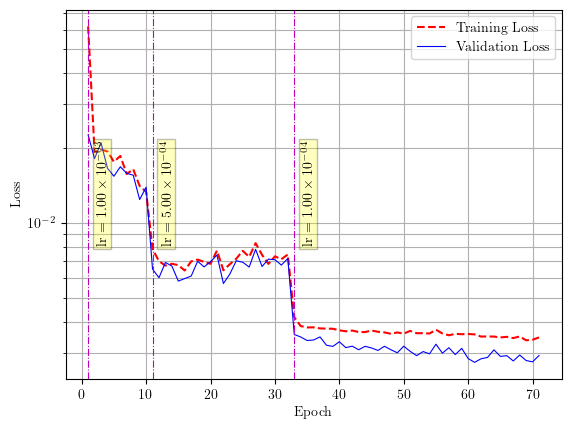

<Figure size 640x480 with 0 Axes>

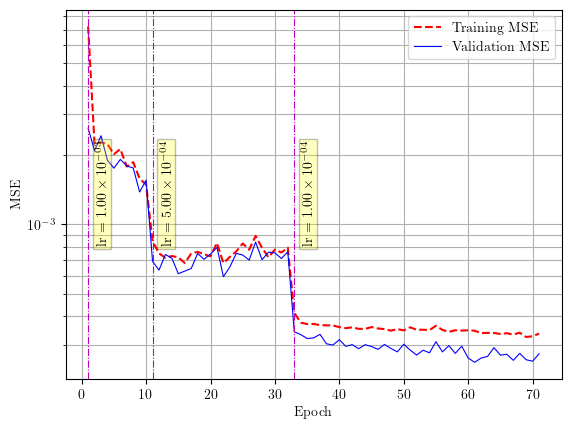

<Figure size 640x480 with 0 Axes>

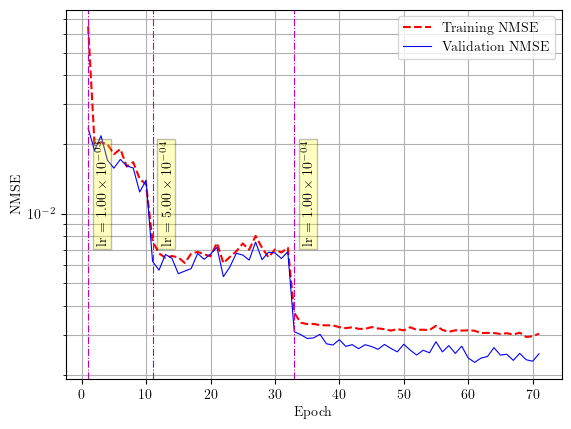

<Figure size 640x480 with 0 Axes>

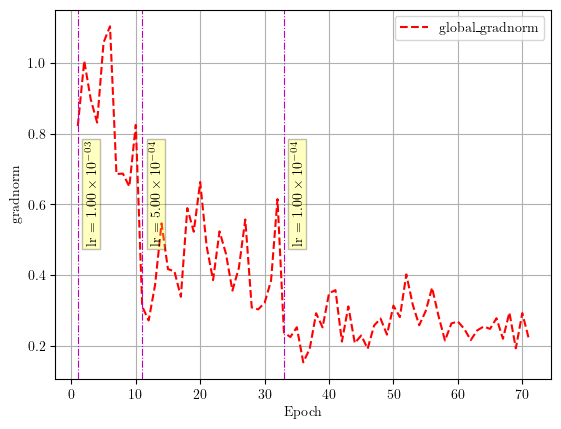



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 10 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : 3.0
8/8 [==============================] - 5s 32ms/step - loss: 0.0047 - mse: 5.1110e-04 - NMSE: 0.0046 - covmat_fro_loss: 0.0000e+00 - global_gradnorm: 0.0000e+00
baseline : 4.5992E-03


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 0.0001 ----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
71/71 [==============================] - ETA: 0s - loss: 0.0066 - mse: 7.5336e-04 - NMSE: 0.0068 - covmat_fro_loss: 6.0981e-04 - global_gradnorm: 0.7169 - tot_time: 0h 0m 19.9s

Epoch 1: val_NMSE did not improve from 0.00460
 - saving loss histories at /home/rkaushik/Doc

71/71 [==============================] - ETA: 0s - loss: 0.0056 - mse: 6.2162e-04 - NMSE: 0.0056 - covmat_fro_loss: 5.5758e-04 - global_gradnorm: 0.6281 - tot_time: 0h 1m 6.1s

Epoch 11: val_NMSE did not improve from 0.00425
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 5s 64ms/step - loss: 0.0056 - mse: 6.2162e-04 - NMSE: 0.0056 - covmat_fro_loss: 5.5759e-04 - global_gradnorm: 0.6289 - val_loss: 0.0044 - val_mse: 4.7777e-04 - val_NMSE: 0.0043 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 12/200
70/71 [============================>.] - ETA: 0s - loss: 0.0055 - mse: 6.0765e-04 - NMSE: 0.0055 - covmat_fro_loss: 5.5052e-04 - global_gradnorm: 0.6035 - tot_time: 0h 1m 10.4s

Epoch 12: val_NMSE did not improve from 0.00425
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AERNN_rnn/AR_rnn_

Epoch 23/200
70/71 [============================>.] - ETA: 0s - loss: 0.0053 - mse: 5.9334e-04 - NMSE: 0.0053 - covmat_fro_loss: 5.4462e-04 - global_gradnorm: 0.6745 - tot_time: 0h 1m 59.6s

Epoch 23: val_NMSE did not improve from 0.00399
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 5s 65ms/step - loss: 0.0053 - mse: 5.9358e-04 - NMSE: 0.0053 - covmat_fro_loss: 5.4494e-04 - global_gradnorm: 0.6747 - val_loss: 0.0044 - val_mse: 4.7126e-04 - val_NMSE: 0.0042 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 24/200
71/71 [==============================] - ETA: 0s - loss: 0.0050 - mse: 5.5311e-04 - NMSE: 0.0050 - covmat_fro_loss: 5.2645e-04 - global_gradnorm: 0.5907 - tot_time: 0h 2m 4.1s

Epoch 24: val_NMSE improved from 0.00399 to 0.00369, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AERNN_rnn/A

Epoch 34: early stopping


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 5e-05 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
71/71 [==============================] - ETA: 0s - loss: 0.0043 - mse: 4.6711e-04 - NMSE: 0.0042 - covmat_fro_loss: 4.8348e-04 - global_gradnorm: 0.4403 - tot_time: 0h 2m 52.6s

Epoch 1: val_NMSE improved from 0.00369 to 0.00329, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 5s 65ms/step - loss: 0.0043 - mse: 4.6711e-04 - NMSE: 0.0042 - covmat_fro_loss: 4.8336e-04 - global_gradnorm: 0.4408 - val_loss: 0.0035 - val_mse: 3.6614e-04 - val_NM

71/71 [==============================] - ETA: 0s - loss: 0.0042 - mse: 4.5377e-04 - NMSE: 0.0041 - covmat_fro_loss: 4.7674e-04 - global_gradnorm: 0.4797 - tot_time: 0h 3m 41.1s

Epoch 12: val_NMSE did not improve from 0.00294
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 4s 63ms/step - loss: 0.0042 - mse: 4.5377e-04 - NMSE: 0.0041 - covmat_fro_loss: 4.7673e-04 - global_gradnorm: 0.4792 - val_loss: 0.0033 - val_mse: 3.3820e-04 - val_NMSE: 0.0030 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 13/200
71/71 [==============================] - ETA: 0s - loss: 0.0041 - mse: 4.4253e-04 - NMSE: 0.0040 - covmat_fro_loss: 4.7070e-04 - global_gradnorm: 0.4676 - tot_time: 0h 3m 45.3s

Epoch 13: val_NMSE did not improve from 0.00294
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AERNN_rnn/AR_rnn

71/71 [==============================] - ETA: 0s - loss: 0.0037 - mse: 3.8602e-04 - NMSE: 0.0035 - covmat_fro_loss: 4.3934e-04 - global_gradnorm: 0.3330 - tot_time: 0h 4m 29.7s

Epoch 9: val_NMSE improved from 0.00256 to 0.00254, saving model to /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/checkpoint-10_outsteps
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-10_outsteps
71/71 [==============================] - 5s 65ms/step - loss: 0.0037 - mse: 3.8602e-04 - NMSE: 0.0035 - covmat_fro_loss: 4.3927e-04 - global_gradnorm: 0.3329 - val_loss: 0.0029 - val_mse: 2.8251e-04 - val_NMSE: 0.0025 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 10/200
71/71 [==============================] - ETA: 0s - loss: 0.0037 - mse: 3.9205e-04 - NMSE: 0.0035 - covmat_fro_loss: 4.4333e-04 - global_gradnorm: 0.3388 - tot_time: 0h 4m 34.2s

Epoch 10: val_NM

<Figure size 640x480 with 0 Axes>

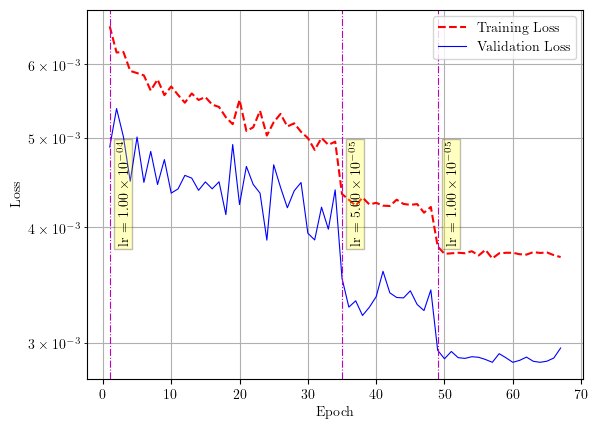

<Figure size 640x480 with 0 Axes>

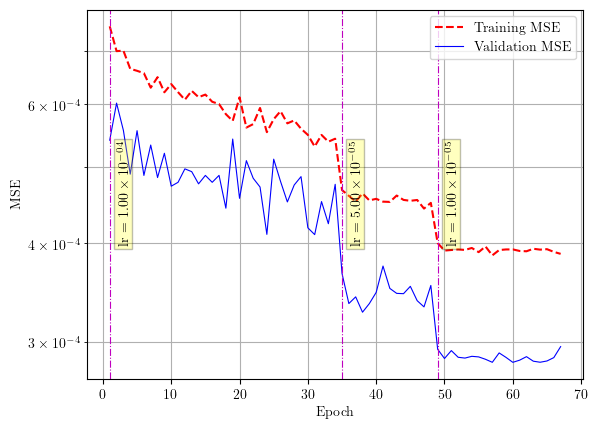

<Figure size 640x480 with 0 Axes>

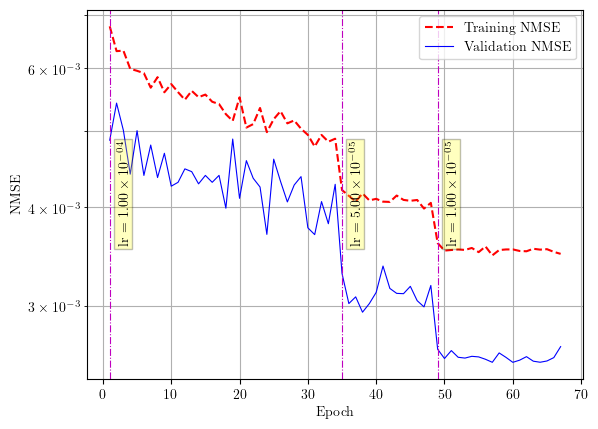

<Figure size 640x480 with 0 Axes>

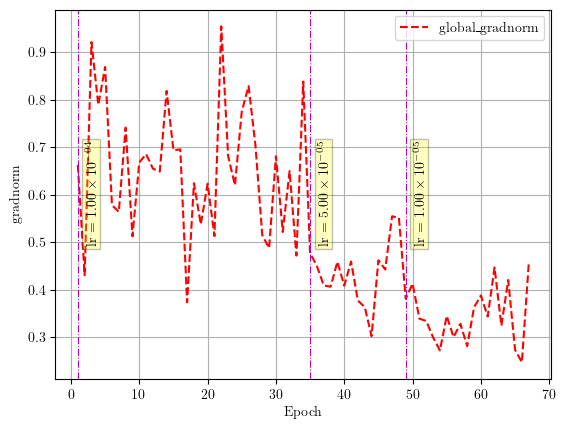



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 30 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : 3.0
7/7 [==============================] - 16s 59ms/step - loss: 0.0087 - mse: 0.0014 - NMSE: 0.0123 - covmat_fro_loss: 0.0000e+00 - global_gradnorm: 0.0000e+00
baseline : 1.2318E-02


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 1e-05 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
58/58 [==============================] - ETA: 0s - loss: 0.0153 - mse: 0.0025 - NMSE: 0.0227 - covmat_fro_loss: 0.0019 - global_gradnorm: 2.5262 - tot_time: 0h 0m 51.9s

Epoch 1: val_NMSE did not improve from 0.01232
 - saving loss histories at /home/rkaushik/Documents/Thes

Epoch 12/200
58/58 [==============================] - ETA: 0s - loss: 0.0146 - mse: 0.0024 - NMSE: 0.0216 - covmat_fro_loss: 0.0019 - global_gradnorm: 2.4427 - tot_time: 0h 2m 8.7s

Epoch 12: val_NMSE did not improve from 0.01163
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 7s 119ms/step - loss: 0.0146 - mse: 0.0024 - NMSE: 0.0216 - covmat_fro_loss: 0.0019 - global_gradnorm: 2.4418 - val_loss: 0.0086 - val_mse: 0.0013 - val_NMSE: 0.0120 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 13/200
58/58 [==============================] - ETA: 0s - loss: 0.0140 - mse: 0.0023 - NMSE: 0.0207 - covmat_fro_loss: 0.0019 - global_gradnorm: 2.4345 - tot_time: 0h 2m 15.6s

Epoch 13: val_NMSE did not improve from 0.01163
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AERNN_rnn/AR_rnn_002/checkpoint

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 7s 117ms/step - loss: 0.0140 - mse: 0.0023 - NMSE: 0.0206 - covmat_fro_loss: 0.0019 - global_gradnorm: 2.5951 - val_loss: 0.0079 - val_mse: 0.0012 - val_NMSE: 0.0111 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 25/200
58/58 [==============================] - ETA: 0s - loss: 0.0141 - mse: 0.0023 - NMSE: 0.0208 - covmat_fro_loss: 0.0019 - global_gradnorm: 2.5741 - tot_time: 0h 3m 38.4s

Epoch 25: val_NMSE did not improve from 0.01107
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 7s 122ms/step - loss: 0.0141 - mse: 0.0023 - NMSE: 0.0208 - covmat_fro_loss: 0.0019 - global_gradnorm: 2.5567 - val_loss: 0.0081 - val_mse: 0.0013 - va

Epoch 37/200
58/58 [==============================] - ETA: 0s - loss: 0.0135 - mse: 0.0022 - NMSE: 0.0198 - covmat_fro_loss: 0.0018 - global_gradnorm: 2.2903 - tot_time: 0h 5m 4.0s

Epoch 37: val_NMSE did not improve from 0.01083
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 7s 119ms/step - loss: 0.0135 - mse: 0.0022 - NMSE: 0.0198 - covmat_fro_loss: 0.0018 - global_gradnorm: 2.2816 - val_loss: 0.0080 - val_mse: 0.0012 - val_NMSE: 0.0111 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 38/200
58/58 [==============================] - ETA: 0s - loss: 0.0139 - mse: 0.0023 - NMSE: 0.0204 - covmat_fro_loss: 0.0018 - global_gradnorm: 2.3486 - tot_time: 0h 5m 11.2s

Epoch 38: val_NMSE did not improve from 0.01083
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AERNN_rnn/AR_rnn_002/checkpoint

Epoch 8/200
58/58 [==============================] - ETA: 0s - loss: 0.0133 - mse: 0.0022 - NMSE: 0.0196 - covmat_fro_loss: 0.0018 - global_gradnorm: 2.3053 - tot_time: 0h 6m 28.8s

Epoch 8: val_NMSE did not improve from 0.01038
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 7s 128ms/step - loss: 0.0133 - mse: 0.0022 - NMSE: 0.0196 - covmat_fro_loss: 0.0018 - global_gradnorm: 2.3049 - val_loss: 0.0077 - val_mse: 0.0012 - val_NMSE: 0.0108 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 9/200
58/58 [==============================] - ETA: 0s - loss: 0.0132 - mse: 0.0022 - NMSE: 0.0194 - covmat_fro_loss: 0.0018 - global_gradnorm: 2.2369 - tot_time: 0h 6m 35.6s

Epoch 9: val_NMSE did not improve from 0.01038
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/L

 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 7s 118ms/step - loss: 0.0130 - mse: 0.0021 - NMSE: 0.0191 - covmat_fro_loss: 0.0018 - global_gradnorm: 2.2023 - val_loss: 0.0075 - val_mse: 0.0011 - val_NMSE: 0.0103 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 21/200
58/58 [==============================] - ETA: 0s - loss: 0.0132 - mse: 0.0021 - NMSE: 0.0193 - covmat_fro_loss: 0.0018 - global_gradnorm: 2.1372Restoring model weights from the end of the best epoch: 11.
 - tot_time: 0h 7m 59.0s

Epoch 21: val_NMSE did not improve from 0.01032
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 7s 119ms/step - loss: 0.0132 - mse: 0.0021 - NMSE: 0.0193 - covmat_fro_loss: 0.0018 - globa

Epoch 11/200
58/58 [==============================] - ETA: 0s - loss: 0.0130 - mse: 0.0021 - NMSE: 0.0191 - covmat_fro_loss: 0.0018 - global_gradnorm: 2.1017 - tot_time: 0h 9m 14.5s

Epoch 11: val_NMSE did not improve from 0.01007
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-30_outsteps
58/58 [==============================] - 7s 117ms/step - loss: 0.0130 - mse: 0.0021 - NMSE: 0.0191 - covmat_fro_loss: 0.0018 - global_gradnorm: 2.1040 - val_loss: 0.0074 - val_mse: 0.0011 - val_NMSE: 0.0102 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 12/200
58/58 [==============================] - ETA: 0s - loss: 0.0130 - mse: 0.0021 - NMSE: 0.0190 - covmat_fro_loss: 0.0018 - global_gradnorm: 2.0950 - tot_time: 0h 9m 21.3s

Epoch 12: val_NMSE did not improve from 0.01007
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AERNN_rnn/AR_rnn_002/checkpoin

<Figure size 640x480 with 0 Axes>

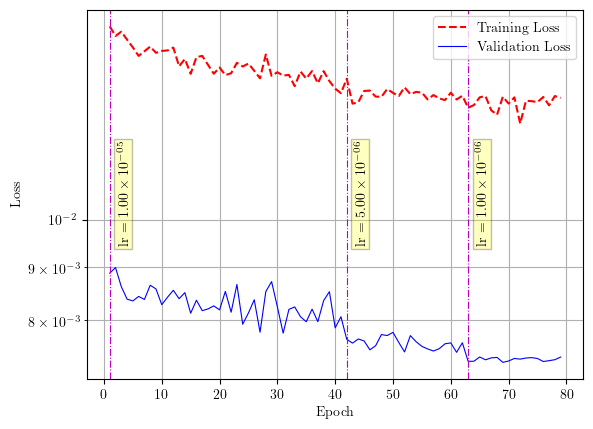

<Figure size 640x480 with 0 Axes>

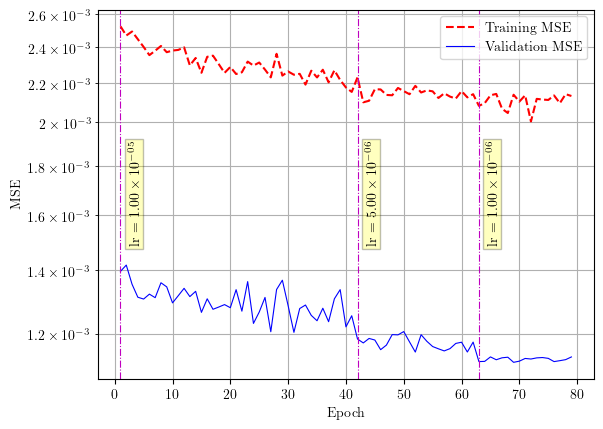

<Figure size 640x480 with 0 Axes>

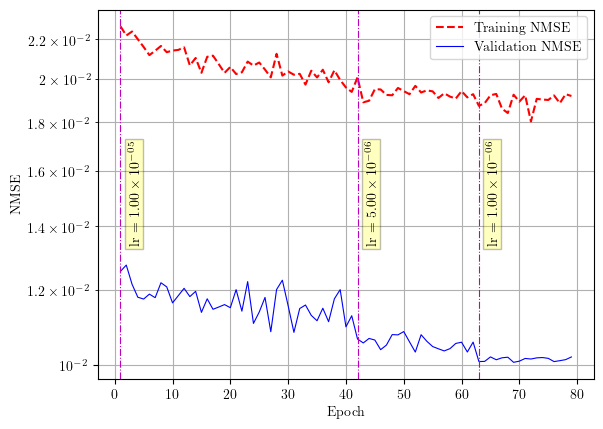

<Figure size 640x480 with 0 Axes>

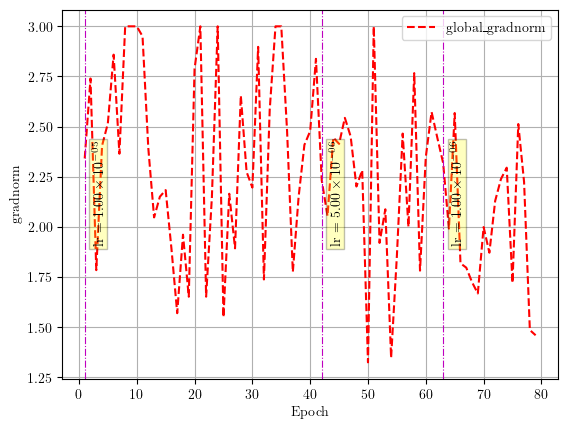



********************************************************************************
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> num_outsteps : 50 <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
********************************************************************************


clipnorm : None, global_clipnorm : 3.0
6/6 [==============================] - 27s 57ms/step - loss: 0.0172 - mse: 0.0039 - NMSE: 0.0348 - covmat_fro_loss: 0.0000e+00 - global_gradnorm: 0.0000e+00
baseline : 3.4791E-02


--------------------------------------------------------------------------------

---------------------------- LEARNING RATE : 1e-06 -----------------------------

--------------------------------------------------------------------------------


Epoch 1/200
49/49 [==============================] - ETA: 0s - loss: 0.0355 - mse: 0.0083 - NMSE: 0.0747 - covmat_fro_loss: 0.0036 - global_gradnorm: 3.0000 - tot_time: 0h 1m 21.4s

Epoch 1: val_NMSE improved from 0.03479 to 0.03408, saving model to /home/rkaushik/Documents/Thesis/MLRO

Epoch 12/200
49/49 [==============================] - ETA: 0s - loss: 0.0337 - mse: 0.0078 - NMSE: 0.0706 - covmat_fro_loss: 0.0035 - global_gradnorm: 3.0000 - tot_time: 0h 2m 56.5s

Epoch 12: val_NMSE did not improve from 0.03280
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 9s 181ms/step - loss: 0.0337 - mse: 0.0078 - NMSE: 0.0706 - covmat_fro_loss: 0.0035 - global_gradnorm: 3.0000 - val_loss: 0.0167 - val_mse: 0.0037 - val_NMSE: 0.0335 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 13/200
49/49 [==============================] - ETA: 0s - loss: 0.0347 - mse: 0.0081 - NMSE: 0.0726 - covmat_fro_loss: 0.0035 - global_gradnorm: 3.0000 - tot_time: 0h 3m 5.3s

Epoch 13: val_NMSE did not improve from 0.03280
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AERNN_rnn/AR_rnn_002/checkpoint

Epoch 9/200
49/49 [==============================] - ETA: 0s - loss: 0.0336 - mse: 0.0078 - NMSE: 0.0702 - covmat_fro_loss: 0.0035 - global_gradnorm: 3.0000 - tot_time: 0h 4m 40.2s

Epoch 9: val_NMSE did not improve from 0.03280
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 8s 172ms/step - loss: 0.0336 - mse: 0.0078 - NMSE: 0.0702 - covmat_fro_loss: 0.0035 - global_gradnorm: 3.0000 - val_loss: 0.0169 - val_mse: 0.0038 - val_NMSE: 0.0339 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 10/200
49/49 [==============================] - ETA: 0s - loss: 0.0340 - mse: 0.0079 - NMSE: 0.0714 - covmat_fro_loss: 0.0035 - global_gradnorm: 3.0000 - tot_time: 0h 4m 48.9s

Epoch 10: val_NMSE did not improve from 0.03280
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints

Epoch 10/200
49/49 [==============================] - ETA: 0s - loss: 0.0349 - mse: 0.0081 - NMSE: 0.0731 - covmat_fro_loss: 0.0035 - global_gradnorm: 3.0000 - tot_time: 0h 6m 24.2s

Epoch 10: val_NMSE did not improve from 0.03280
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AERNN_rnn/AR_rnn_002/checkpoints/LossHistoriesCheckpoint-50_outsteps
49/49 [==============================] - 9s 177ms/step - loss: 0.0349 - mse: 0.0081 - NMSE: 0.0731 - covmat_fro_loss: 0.0035 - global_gradnorm: 3.0000 - val_loss: 0.0167 - val_mse: 0.0037 - val_NMSE: 0.0334 - val_covmat_fro_loss: 0.0000e+00 - val_global_gradnorm: 0.0000e+00
Epoch 11/200
49/49 [==============================] - ETA: 0s - loss: 0.0327 - mse: 0.0076 - NMSE: 0.0682 - covmat_fro_loss: 0.0034 - global_gradnorm: 3.0000 - tot_time: 0h 6m 32.6s

Epoch 11: val_NMSE did not improve from 0.03280
 - saving loss histories at /home/rkaushik/Documents/Thesis/MLROM/new_ks/saved_AR_AERNN_rnn/AR_rnn_002/checkpoin

<Figure size 640x480 with 0 Axes>

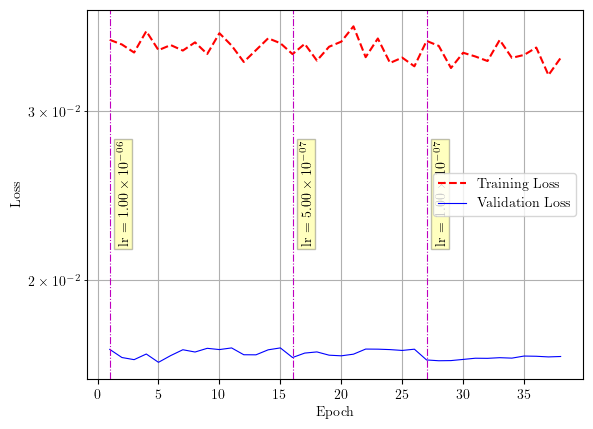

<Figure size 640x480 with 0 Axes>

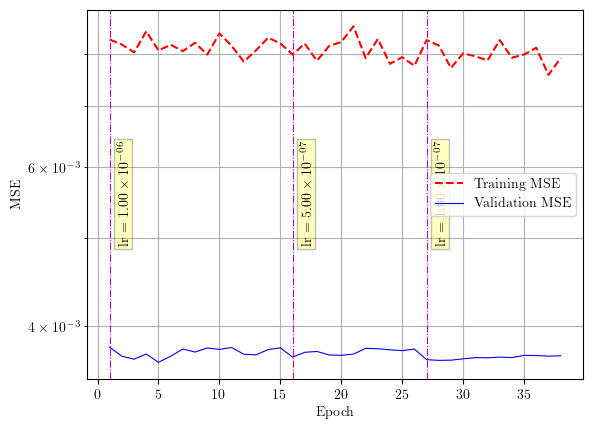

<Figure size 640x480 with 0 Axes>

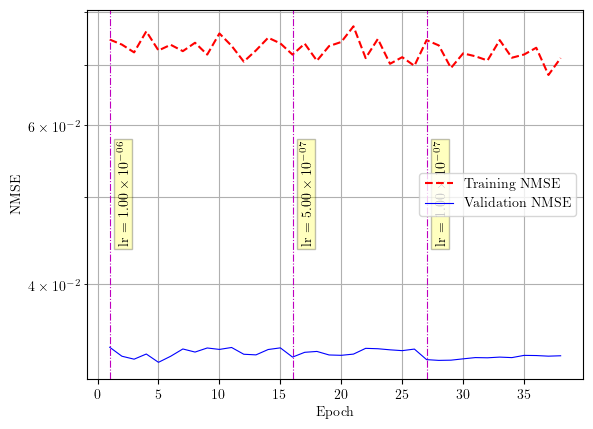

<Figure size 640x480 with 0 Axes>

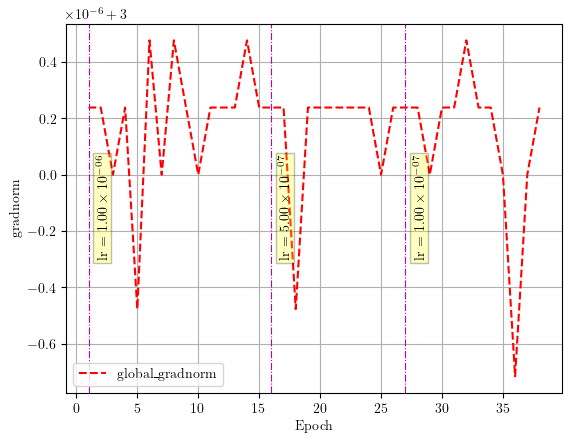

<Figure size 640x480 with 0 Axes>

In [19]:
global_clipnorm = None
for kk in range(len(T_sample_output)):

    num_outsteps = int((T_sample_output[kk] + 0.5*dt_rnn)//dt_rnn)
    if type(freeze_layers) == type(None):
        freeze_layers_thisoutstep = []
    else:
        if kk > len(freeze_layers) - 1:
            freeze_layers_thisoutstep = freeze_layers[-1]
        else:
            freeze_layers_thisoutstep = freeze_layers[kk]
        
        if type(freeze_layers_thisoutstep) == type(None):
            freeze_layers_thisoutstep = []
            
    if type(batch_size) == type([]):
        if kk > len(batch_size) - 1:
            batch_size_thisoutstep = batch_size[-1]
        else:
            batch_size_thisoutstep = batch_size[kk]
    else:
        batch_size_thisoutstep = batch_size

    total_s_len = 80
    sep_lr_s = ' num_outsteps : {} '.format(num_outsteps)
    sep_lr_s = int((total_s_len - len(sep_lr_s))//2)*'>' + sep_lr_s
    sep_lr_s = sep_lr_s + (total_s_len-len(sep_lr_s))*'<'
    print('\n\n' + '*'*len(sep_lr_s))
    print('' + sep_lr_s+'')
    print('*'*len(sep_lr_s) + '\n\n')

    print('clipnorm : {}, global_clipnorm : {}'.format(clipnorm, global_clipnorm))
    
    trainAERNN(
        create_data_for_RNN,
        Autoencoder,
        AR_RNN,
        all_data,
        AR_AERNN_GRU,
        dt_rnn=dt_rnn,
        T_sample_input=T_sample_input,
        T_sample_output=T_sample_output[kk],
        T_offset=T_offset,
        boundary_idx_arr=boundary_idx_arr,
        delta_t=delta_t,
        params=params,
        normalize_dataset=normalize_dataset,
        stddev_multiplier=stddev_multiplier,
        skip_intermediate=skip_intermediate,
        normalization_type=normalization_type,
        normalization_constant_arr_aedata=normalization_constant_arr_aedata,
        normalization_constant_arr_rnndata=normalization_arr_rnn,
        learning_rate_list=learning_rate_list[kk],
        epochs=epochs[kk],
        patience=patience[kk],
        loss_weights=loss_weights,
        min_delta=min_delta,
        lambda_reg=lambda_reg,
        stddev_rnn=stddev,
        stateful=False,
        behaviour=behaviour,
        strategy=strategy,
        dir_name_rnn=dir_name_rnn,
        dir_name_AR_AErnn=dir_name_ARrnn,
        batch_size=batch_size_thisoutstep,
        load_file_rnn=load_file_rnn,
        wt_file_rnn=wt_file_rnn,
        load_file_ae=load_file_ae,
        wt_file_ae=wt_file_ae,
        covmat_lmda=covmat_lmda,
        readAndReturnLossHistories=readAndReturnLossHistories,
        mytimecallback=mytimecallback,
        plot_losses=plot_losses,
        SaveLosses=SaveLosses,
        train_split=train_split,
        test_split=test_split,
        val_split=val_split,
        freeze_layers=freeze_layers_thisoutstep,
        clipnorm=clipnorm,
        global_clipnorm=global_clipnorm,
        use_ae_data=use_ae_data,
    )
    
    wt_file_rnn = dir_name_ARrnn+'/final_net/final_net-{}_outsteps_rnn_weights.h5'.format(num_outsteps)
    wt_file_ae = dir_name_ARrnn+'/final_net/final_net-{}_outsteps_ae_weights.h5'.format(num_outsteps)
    
    with open(dir_name_ARrnn+'/final_net/losses-{}_outsteps.txt'.format(num_outsteps), 'r') as fl:
        lines = fl.readlines()

    loss_dict = eval(''.join(lines))
    train_global_gradnorm_hist = loss_dict['train_global_gradnorm_hist']
    # lr_change = loss_dict['lr_change']
    # trained_epochs = len(train_global_gradnorm_hist)
    # if lr_change[-1] - lr_change[-2] == epochs[kk][-1]:
    #     global_clipnorm = train_global_gradnorm_hist[-1]
    # else:
    #     global_clipnorm = train_global_gradnorm_hist[-patience[kk][-1]]

    # alpha1 = 0.9
    # alpha2 = 0.1
    # global_clipnorm = train_global_gradnorm_hist[0]
    # for i in range(1, len(train_global_gradnorm_hist)):
    #     global_clipnorm = alpha1*global_clipnorm + alpha2*train_global_gradnorm_hist[i]

#     grad_norm_decay = 0.95
#     idxs_to_ignore = 0

#     global_clipnorm = np.max(train_global_gradnorm_hist[idxs_to_ignore:])
#     # global_clipnorm = 0.25 * np.round(4*global_clipnorm)
#     global_clipnorm = grad_norm_decay * global_clipnorm
    idxs_to_ignore = 0
    global_clipnorm_min = 3.0
    global_clipnorm = np.max(train_global_gradnorm_hist[idxs_to_ignore:])
    global_clipnorm = 0.1 * np.round(10*global_clipnorm)
    global_clipnorm = max(global_clipnorm, global_clipnorm_min)

In [20]:
a = 123e-5
a

0.00123

In [21]:
s = '{:E}'.format(a)
s

'1.230000E-03'

In [22]:
idx = s.find('E')
num = float(s[0:idx])
10**float(s[idx+1:])

0.001

In [23]:
### Training the combined AE-RNN


# 